# Goals
If a time series data of a physical process is given the student should be able to analyze and forecast the data. The student should also be able to evaluate the error of the method.

## Problem
Suppose we have a damped harmonic oscillator and its position co-ordinates are measured at every time interval $dt $.

The time points \( t \) are generated from 0 to \( T \) with a step size \( dt \):
$t = 0, \, dt, \, 2dt, \, \ldots, \, (n-1)dt$
where $( n = \frac{T}{dt} $).

The position \( x(t) \) of the damped harmonic oscillator is given by:
$x(t) = A e^{-bt} \cos(\omega t)$

where:
\begin{align*}
A; \text{ is the amplitude}, \\
b; \text{ is the damping coefficient}, \\
\omega; \text{ is the angular frequency}.
\end{align*}

The position data is the result of measurements, which by definition come with limited precision. 
The measurement errors act as Gaussian noise over thre true positions. 
The noisy position data $( x_{\text{noisy}}(t) $) is therefore obtained by adding Gaussian noise to the true position data:

$x_{\text{noisy}}(t) = x(t) + \epsilon(t)$

where $( \epsilon(t) \sim \mathcal{N}(0, \sigma^2) $) is normally distributed noise with mean 0 and standard deviation $( \sigma $). 

The code given in the cell below stores the noisy time dependent position and the time information of the oscillator to an excel file.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(42)

# Define parameters for the damped harmonic oscillator
A = 1.0    # Amplitude
b = 0.05   # Damping coefficient
omega = 2 * np.pi / 5  # Angular frequency
T = 100    # Total time
dt = 0.1   # Time step

# Generate time points
t = np.arange(0, T, dt)

# Generate the damped oscillation data
x = A * np.exp(-b * t) * np.cos(omega * t)

# Add some noise to the data
noise = np.random.normal(scale=0.1, size=len(t))
x_noisy = x + noise

# Create a DataFrame
df = pd.DataFrame({'Time': t, 'Position': x_noisy})

df.to_excel('damped_oscillator.xlsx','series')

### Data importation and visualization
Import the excel file and visulaize the data with different techniques

In [2]:
# Exercise 1 
# Upload the excel file damped_oscillator.xlsx using pandas to a dataframe object
series = pd.read_excel('damped_oscillator.xlsx',
                    sheet_name='series', header=0, index_col=0,
                     dtype=float) 

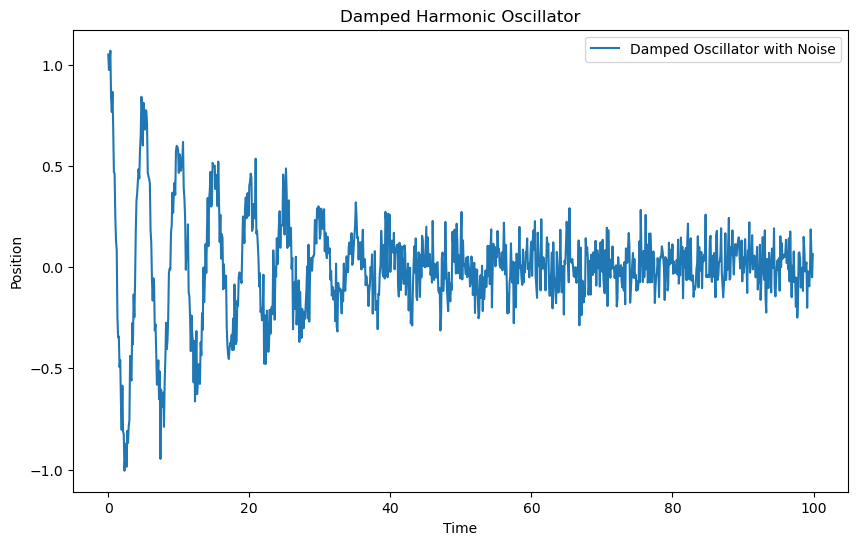

In [3]:
# Exercise 2
# Plot time (x-axis) versus position (y-ais) using matplotlib pyplot. Add appropriate labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(series['Time'], series['Position'], label='Damped Oscillator with Noise')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator')
plt.legend()
plt.show()

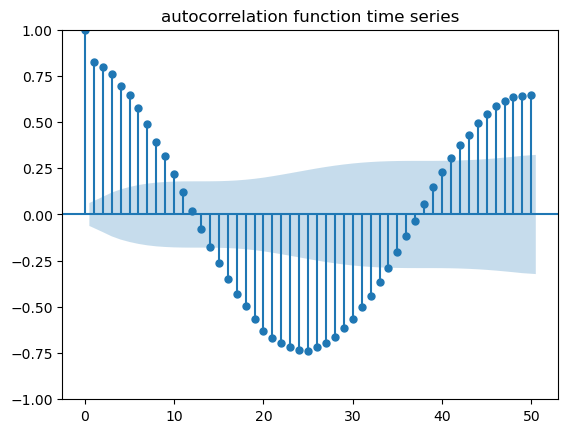

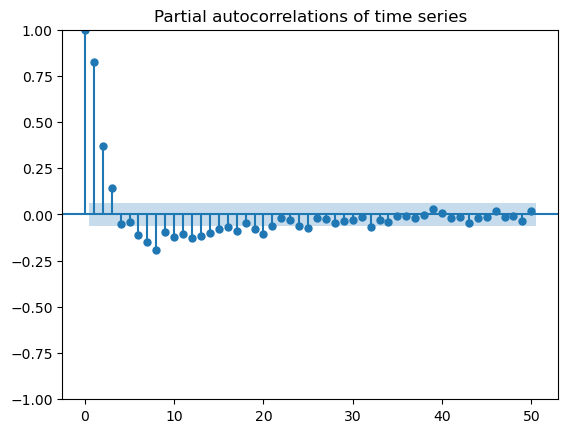

In [4]:
# Exercise 3
# Plot the autocorrelation function time series of the position data (50 lags for example)
# Plot the partial autocorrelation function time series of the position data (50 lags for example)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series['Position'], title='autocorrelation function time series', lags=50)
plot_pacf(series['Position'], title='Partial autocorrelations of time series', lags=50)
plt.show()

### Modeling and forecasting
After basic drawing and visulazation of the data try to analyze the position data and do some forcasting using the SARIMAX model

In [5]:
# Exercise 4
# import itertools, and use it to generate different combinations of parameters for the SARIMAX model
import itertools

# Define the p, q parameters to take any value between 1 and 2, and the d parameter to take any value between 0 and 1
p = q = range(1, 3)
d = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets (i.e., P, D, Q)
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]

In [ ]:
# Exercise 5
# Define a SARIMAX the model and identify the optimal parameters according to the AIC criterion
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Indentification of best model from different combinations of pdq and seasonal_pdq
best_score, best_param, best_paramSeasonal = float("inf"), None, None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(series['Position'], order=param, seasonal_order=param_seasonal, enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_score:
                best_score, best_param, best_paramSeasonal = results.aic, param, param_seasonal
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue # if fit fails, just continue to the next parameters combionation

ARIMA(1, 0, 1)x(1, 0, 1, 10) - AIC:-1321.8886521814675
ARIMA(1, 0, 1)x(1, 0, 2, 10) - AIC:-1346.2834444452194
ARIMA(1, 0, 1)x(1, 1, 1, 10) - AIC:-1250.7218858767671
ARIMA(1, 0, 1)x(1, 1, 2, 10) - AIC:-1256.5750198181895
ARIMA(1, 0, 1)x(2, 0, 1, 10) - AIC:-1362.2127148255443
ARIMA(1, 0, 1)x(2, 0, 2, 10) - AIC:-1474.6775479348444
ARIMA(1, 0, 1)x(2, 1, 1, 10) - AIC:-1285.0891708229672
ARIMA(1, 0, 1)x(2, 1, 2, 10) - AIC:-1293.1568976349135
ARIMA(1, 0, 2)x(1, 0, 1, 10) - AIC:-1346.0730234032367
ARIMA(1, 0, 2)x(1, 0, 2, 10) - AIC:-1368.5673001199773
ARIMA(1, 0, 2)x(1, 1, 1, 10) - AIC:-1274.0543601446589
ARIMA(1, 0, 2)x(1, 1, 2, 10) - AIC:-1280.6929399274368
ARIMA(1, 0, 2)x(2, 0, 1, 10) - AIC:-1381.94639784835
ARIMA(1, 0, 2)x(2, 0, 2, 10) - AIC:-1479.0468986029673
ARIMA(1, 0, 2)x(2, 1, 1, 10) - AIC:-1307.607073731915
ARIMA(1, 0, 2)x(2, 1, 2, 10) - AIC:-1313.303406742889
ARIMA(1, 1, 1)x(1, 0, 1, 10) - AIC:-1322.4749305320736
ARIMA(1, 1, 1)x(1, 0, 2, 10) - AIC:-1344.1376727811394
ARIMA(1, 1, 1)

In [ ]:
# Exercise 6
# Print the best set of parameters according to the AIC
print('The best model is ARIMA{}x{} - AIC:{}'.format(best_param, best_paramSeasonal, best_score))

In [ ]:
# Exercise 7
# Fit the model once again using teh optimal parameters, and print a summary of the results
mod = SARIMAX(series['Position'], order=best_param, seasonal_order=best_paramSeasonal, enforce_invertibility=False)
results=mod.fit()
print(results.summary())

In [ ]:
# Exercise 8
# Forecast future values for 50 steps
n_forecast = 50  # Number of steps to forecast
forecast = results.get_forecast(steps=n_forecast)
forecast_index = np.arange(T, T + n_forecast * dt, dt)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()


In [ ]:
# Exercise 9
# Plot the results, the predicted trend according to the model, and the forecast
plt.figure(figsize=(10, 6))
predictions = results.predict()
# Plot the original data i.e. time (x-axis) vs position
plt.plot(series['Time'], series['Position'], label='Observed', color='blue')
# Plot the time (x-axis) vs predictions 
plt.plot(series['Time'], predictions, label='Model', color='green')
# Plot the forecast index (x-axis) vs forecast values
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')

plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator with SARIMAX Forecast')
plt.legend()
plt.show()

### Error analysis
Analyse the errors of the predictions

In [ ]:
# # Exercise 10
# Compute the:
#   Sum of Squares Total (SST),
#   Summ of Squares Error (SSE),
#   Sum of Squares Regression (SSR),
# and then the coefficient of determination (R²) 
observed = series['Position']
mean_observed = np.mean(observed)
sst = np.sum((observed - mean_observed) ** 2)
sse = np.sum((observed - predictions) ** 2)
ssr = sst - sse
r2 = 1 - (sse / sst)

# Print the results
print(f'SST: {sst:.2f}')
print(f'SSE: {sse:.2f}')
print(f'SSR: {ssr:.2f}')
print(f'R²: {r2:.2f}')


In [ ]:
# # Exercise 11
# The degrees of freedom are 
n = len(observed)  # Number of observations
p = len(results.params)  # Number of predictors in SARIMAX

# Calculate MST, MSE, MSR, and F-score
mst = sst / (n - 1)
mse = sse / (n - p - 1)
msr = ssr / p
f_score = msr / mse

# Print the results
print(f'MST: {mst:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MSR: {msr:.2f}')
print(f'F-score: {f_score:.2f}')

### Holt's linear model

While SARIMAX provides a good forecast for the future points, other methods such as Holt's linear metod do not work as well in the case of this data. Let's verify that.

In [ ]:
# Exercise 12
# Fit the Holt's linear trend model to same data
from statsmodels.tsa.api import Holt

model = Holt(df['Position'])
holt_results = model.fit(optimized=True)

In [ ]:
# Exercise 13
# Make in-sample predictions and forecasts for future points (50 steps)
holt_predictions = holt_results.fittedvalues
forecast_steps = 50
holt_forecast = holt_results.forecast(steps=forecast_steps)
forecast_index = np.arange(T, T + n_forecast * dt, dt)

In [ ]:
# Exercise 14
# Plot the original data, the predicted trend according to Holt's linear model, and the forecast for future points
predictions = results.predict()
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Position'], label='Observed', color='blue')
plt.plot(df['Time'], holt_predictions, label='Predicted', color='red')
plt.plot(forecast_index, holt_forecast, label='Forecasted', color='pink')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator: Observed vs Predicted')
plt.legend()
plt.show()